In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
datos = np.genfromtxt('EC2110.TXT')

In [0]:
## PARA CAMBIAR EL FORMATO DEL TIEMPO DE LAS BITACORAS 
ind = np.arange(1,13)

T_crono = []

for i in ind:
  t_inc = open('Multi Timer{}.txt'.format(i), mode='r')# dtype='str') #'rb' puede que sea modo lectura + "binary mode"
  text=t_inc.read()
  t_inc.close()
  prueba=text.split(';')
  Auxx = []
  num = int(((len(prueba)+1)/2) - 1)
  for j in range(num):
    (h, m, s) = (prueba[1+(2*j)].split(':'))
    aux = (float(int(h) * 3600 + int(m) * 60 + float(s)))/60
    Auxx.append(aux)
  T_crono.append(Auxx)#, float[newx]) #EN MINUTOS

#A qué corresponden cada uno 
ind_comienzo_exp = [1,4,8]
ind_ini_med = [3,7,10]
ind_fin_med = [0,5,9]
ind_toques_S9 = [2,6,11]

"""
Multi Timer 1 : fin med
Multi Timer 2 : comienzo exp
Multi Timer 3 : toques sensor
Multi Timer 4 : inicio med
Multi Timer 5 : comienzo exp
Multi Timer 6 : fin med
Multi Timer 7 : toques sensor
Multi Timer 8 : inicio med
Multi Timer 9 : comienzo exp
Multi Timer 10 : fin med
Multi Timer 11 : inicio med
Multi Timer 12 : toques sensor
"""
"""
startExp = T_crono[ind_comienzo_exp]
starmed = T_crono[ind_ini_med]
endmed = T_crono[ind_fin_med]
toquesS9 = T_crono[ind_toques_S9]
"""


'\nstartExp = T_crono[ind_comienzo_exp]\nstarmed = T_crono[ind_ini_med]\nendmed = T_crono[ind_fin_med]\ntoquesS9 = T_crono[ind_toques_S9]\n'

In [0]:
def expo(x, d, e, f):
  y = d - (e/f)*(1- np.exp(-f*x))
  return y

def inversa(y, a, b, c):
  x = np.log((1+(c/b)*(y-a))**(-1/c))
  return x

def df_exp(x,params):
  b=params[1]
  c=params[2]
  df=np.zeros(4)
  df[0]=-b*np.exp(-c*x)
  df[1]=1
  df[2]=-(1-np.exp(-c*x))/c
  df[3]=b*np.exp(-c*x)*(np.exp(c*x)-c*x-1)/(c**2)
  return df

def prediccion_exp(x,error_x,params,cov_params):
    df=df_exp(x,params)
    Y=params[0]-params[1]*(1-np.exp(-params[2]*x))/params[2]
    sigma_Y=np.sqrt((df[0]*error_x)**2+(df[1]**2)*cov_params[0,0]
                    +((df[2]**2)*cov_params[1,1])+((df[3]**2)*cov_params[2,2])
                   +2*df[1]*df[2]*cov_params[0,1]+2*df[1]*df[3]*cov_params[0,2]
                    +2*df[2]*df[3]*cov_params[1,2])
    return(Y,sigma_Y)

def prediccion(params,sigma,tiempo):
  fuerza = np.linspace(0,50,len(tiempo))
  err_f = 0.05
  yp, U, L = np.zeros(len(fuerza)), np.zeros(len(fuerza)), np.zeros(len(fuerza))
  
  for i in range(len(fuerza)):
    yp[i] = params[0]-params[1]*(1-np.exp(-params[2]*fuerza[i]))/params[2]
    U[i] = yp[i]+sigma
    L[i] = yp[i]-sigma
  return(L, U)
  
def conversion(lecturas,L,U,parametros):
  fuerza = np.linspace(0,50,len(lecturas))
  F_medio, F_inf, F_sup = [], [], []
  for lectura in lecturas:
    if inversa(lectura,parametros[0],parametros[1],parametros[2])<0:
      F_medio.append(0)
    else:
      F_medio.append(inversa(lectura,parametros[0],parametros[1],parametros[2]))
    if (U[0]<=lectura)&(U[-1]>=lectura):
      F_inf.append(fuerza[np.where(U>=lectura)[0][0]])
    elif(U[0]>=lectura):
      F_inf.append(0)
    else:
      F_inf.append(50)
    if (L[0]<=lectura)&(L[-1]>=lectura):
      F_sup.append(fuerza[np.where(L>=lectura)[0][0]])
    elif (L[-1]<=lectura):
      F_sup.append(1000)
    else:
      F_sup.append(0)
      
  #inf_sup = np.zeros((2,len(F_sup)))
  inf = np.abs(np.array(F_medio)-np.array(F_inf))
  sup = np.abs(np.array(F_sup)-np.array(F_medio))
  return(F_medio,F_inf,F_sup,inf,sup)

#Los parámetros y errores de los ajustes de la calibración para los 16 sensores 
sigma_sensores = [28.50743680486602,
 40.035691410770845,
 75.92682903325516,
 37.03330093530448,
 37.009443901406705,
 29.738682826159973,
 70.97764187204398,
 52.15533466056375,
 32.497045960260515,
 32.44547192294861,
 33.00851416365968,
 32.1256839653405,
 35.28207328701349,
 117.57390633160517,
 33.028885953149796,
 68.26437490680551]

parametros = [[106.41947076466457, -93.19677934017143, 0.12107610609283553],
 [126.78312923047172, -85.5264479552026, 0.11903990588285217],
 [93.85451830707815, -66.60775025362386, 0.08475087434184155],
 [116.85965426183508, -65.5798643570724, 0.09242389886896074],
 [111.87261496718325, -84.75542120314589, 0.11560405472068797],
 [159.69200871089643, -81.13983417220132, 0.11875730926532743],
 [90.61103401839009, -79.48815384847913, 0.11219863241363438],
 [130.6512236088824, -72.94526098040387, 0.09994115387879862],
 [126.82871565624373, -88.91615056400045, 0.1218001426442211],
 [111.53976550308157, -106.12875612182499, 0.14348676912373698],
 [138.84587435969445, -79.23258416694709, 0.11088325226752217],
 [139.63394524284678, -92.54706726093359, 0.1295163290074966],
 [189.37884961172446, -86.93642955241872, 0.12675103587348738],
 [108.59744166006652, -105.82005879248325, 0.13565341602041484],
 [194.57685444323965, -84.51512629664856, 0.12626997956415545],
 [123.2184532382302, -53.599930309066224, 0.10009778285771953]]

label_sens=['Sensor 0','Sensor 1','Sensor 2','Sensor 3','Sensor 4','Sensor 5',
       'Sensor 6','Sensor 7','Sensor 8','Sensor 9','Sensor 10','Sensor 11',
       'Sensor 12','Sensor 13','Sensor 14','Sensor 15']

In [4]:
inimed1, finmed1 = 720, 7693
inimed2, finmed2 = 7695, 10361
inimed3, finmed3 = 10363 , 23003
inimed4, finmed4 = 23005 , 28868


"""
Multi Timer 1 : fin med
Multi Timer 2 : comienzo exp
Multi Timer 3 : toques sensor
Multi Timer 4 : inicio med
Multi Timer 5 : comienzo exp
Multi Timer 6 : fin med
Multi Timer 7 : toques sensor
Multi Timer 8 : inicio med
Multi Timer 9 : comienzo exp
Multi Timer 10 : fin med
Multi Timer 11 : inicio med
Multi Timer 12 : toques sensor
"""


'\nMulti Timer 1 : fin med\nMulti Timer 2 : comienzo exp\nMulti Timer 3 : toques sensor\nMulti Timer 4 : inicio med\nMulti Timer 5 : comienzo exp\nMulti Timer 6 : fin med\nMulti Timer 7 : toques sensor\nMulti Timer 8 : inicio med\nMulti Timer 9 : comienzo exp\nMulti Timer 10 : fin med\nMulti Timer 11 : inicio med\nMulti Timer 12 : toques sensor\n'

In [0]:
tiempo_med1_crudo = (datos[inimed1:finmed1,0]-datos[inimed1,0])/60000
lectura_med1_crudo = []
for i in range(15):
  lectura_med1_crudo.append(datos[inimed1:finmed1,i+1])
  
tiempo_med2_crudo = (datos[inimed3:finmed3,0]-datos[inimed2,0])/60000
"""
t_ini1 = T_crono[7][2]
t_ini2 = T_crono[7][3]
t_ini3 = T_crono[7][4]
t_ini4 = T_crono[7][5]
t_ini5 = T_crono[7][6]

t_fin1 = T_crono[5][2]
t_fin2 = T_crono[5][3]
t_fin3 = T_crono[5][4]
t_fin4 = T_crono[5][5]
t_fin5 = T_crono[5][6]
"""
#print(t_ini1)

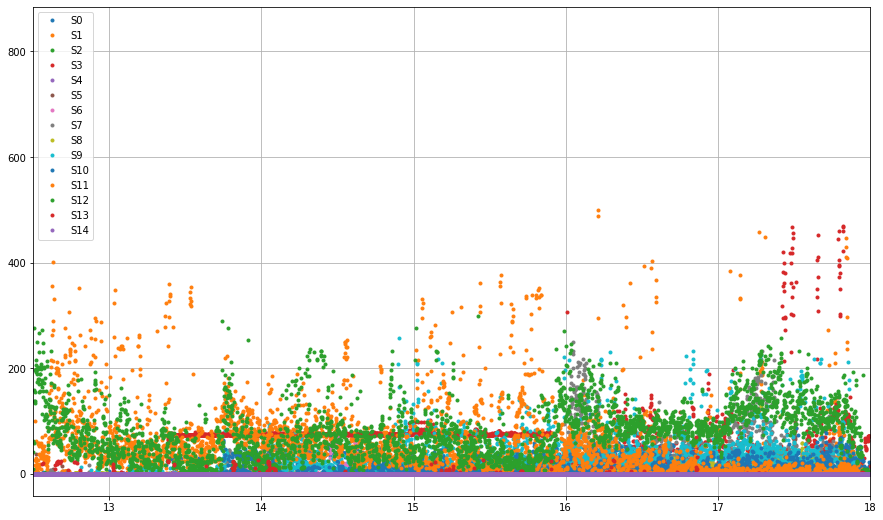

In [6]:
plt.figure(figsize=(15,9))
for i in range(15): #[2]:#
  #plt.plot((datos[inimed2:finmed2,0]-datos[inimed2,0]*np.ones(len(datos[inimed2:finmed2,0])))/60000,datos[inimed2:finmed2,i+1], '.', label='S'+str(i))
  plt.plot(tiempo_med2_crudo,datos[inimed3:finmed3,i+1], '.', label='S'+str(i))
  plt.grid()
"""  
for j in range(len(T_crono[7])):
  plt.axvline(T_crono[7][j])#, label='inicios')
  plt.axvline(T_crono[5][j], color='r')#, label='finales')
for k in range(len(T_crono[6])):
  plt.axvline(T_crono[6][k], color='g', linestyle='--')#, label='toques')
"""  
plt.legend()
plt.xlim(12.5,18)
plt.show()

In [37]:
t1in_med2 = 5505 #tiempo_med2_crudo[5505]
t2in_med2 = 6240 #tiempo_med2_crudo[6240]
t3in_med2 = 7003 #tiempo_med2_crudo[7003]
t4in_med2 = 7700 #tiempo_med2_crudo[7700]
t5in_med2 = 8485 #tiempo_med2_crudo[8485]

t1fin_med2 = 6189 #tiempo_med2_crudo[6189]
t2fin_med2 = 6902 #tiempo_med2_crudo[6902]
t3fin_med2 = 7557 #tiempo_med2_crudo[7557]
t4fin_med2 = 8371 #tiempo_med2_crudo[8371]
t5fin_med2 = 8933 #tiempo_med2_crudo[8933]

n_personas = 15
volumen = [1.61, 1.50, 1.39, 1.31, 1.27] #en m³

densidad = []
for i in range(5):
  densidad.append(n_personas/volumen[i])

print(densidad)

[9.316770186335404, 10.0, 10.79136690647482, 11.450381679389313, 11.811023622047244]


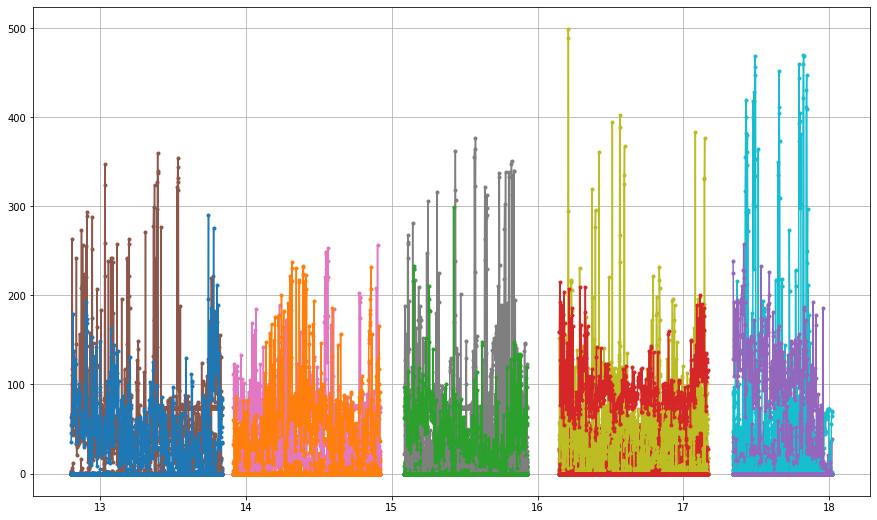

In [8]:
plt.figure(figsize=(15,9))
for i in range(15): #[2]:#
  plt.plot(tiempo_med2_crudo[t1in_med2:t1fin_med2],datos[inimed3+t1in_med2:inimed3+t1fin_med2,i+1], '.-')#, label='S'+str(i))
  plt.plot(tiempo_med2_crudo[t2in_med2:t2fin_med2],datos[inimed3+t2in_med2:inimed3+t2fin_med2,i+1], '.-')
  plt.plot(tiempo_med2_crudo[t3in_med2:t3fin_med2],datos[inimed3+t3in_med2:inimed3+t3fin_med2,i+1], '.-')
  plt.plot(tiempo_med2_crudo[t4in_med2:t4fin_med2],datos[inimed3+t4in_med2:inimed3+t4fin_med2,i+1], '.-')
  plt.plot(tiempo_med2_crudo[t5in_med2:t5fin_med2],datos[inimed3+t5in_med2:inimed3+t5fin_med2,i+1], '.-')  
  plt.grid()
#plt.legend()
plt.show()

In [0]:
#Convertimos la lectura a fuerza para la medición en el subteB del 16/9
tiempo1 = tiempo_med2_crudo[t1in_med2:t1fin_med2]

#L, U = np.zeros((len(tiempo), 16)), np.zeros((len(tiempo), 16))
F_medio1 = np.zeros((len(tiempo1), 15))
F_inf = np.zeros((len(tiempo1), 15))
F_sup = np.zeros((len(tiempo1), 15))
inf = np.zeros((len(tiempo1), 15))
sup = np.zeros((len(tiempo1), 15))

for j in range(15):
  L, U = prediccion(parametros[j], sigma_sensores[j], tiempo1)
  #L[:,j], U[:,j] = prediccion(parametros[j], sigma_sensores[j], tiempo)
  F_medio1[:,j], F_inf[:,j], F_sup[:,j], inf[:,j], sup[:,j] = conversion(datos[inimed3+t1in_med2:inimed3+t1fin_med2,j+1], L, U, parametros[j])

tiempo2 = tiempo_med2_crudo[t2in_med2:t2fin_med2]

#L, U = np.zeros((len(tiempo), 16)), np.zeros((len(tiempo), 16))
F_medio2 = np.zeros((len(tiempo2), 15))
F_inf = np.zeros((len(tiempo2), 15))
F_sup = np.zeros((len(tiempo2), 15))
inf = np.zeros((len(tiempo2), 15))
sup = np.zeros((len(tiempo2), 15))

for j in range(15):
  L, U = prediccion(parametros[j], sigma_sensores[j], tiempo2)
  #L[:,j], U[:,j] = prediccion(parametros[j], sigma_sensores[j], tiempo)
  F_medio2[:,j], F_inf[:,j], F_sup[:,j], inf[:,j], sup[:,j] = conversion(datos[inimed3+t2in_med2:inimed3+t2fin_med2,j+1], L, U, parametros[j])

tiempo1 = tiempo_med2_crudo[t3in_med2:t3fin_med2]
#L, U = np.zeros((len(tiempo), 16)), np.zeros((len(tiempo), 16))
F_medio3 = np.zeros((len(tiempo1), 15))
F_inf = np.zeros((len(tiempo1), 15))
F_sup = np.zeros((len(tiempo1), 15))
inf = np.zeros((len(tiempo1), 15))
sup = np.zeros((len(tiempo1), 15))

for j in range(15):
  L, U = prediccion(parametros[j], sigma_sensores[j], tiempo1)
  #L[:,j], U[:,j] = prediccion(parametros[j], sigma_sensores[j], tiempo)
  F_medio3[:,j], F_inf[:,j], F_sup[:,j], inf[:,j], sup[:,j] = conversion(datos[inimed3+t3in_med2:inimed3+t3fin_med2,j+1], L, U, parametros[j])
  
tiempo1 = tiempo_med2_crudo[t4in_med2:t4fin_med2]
#L, U = np.zeros((len(tiempo), 16)), np.zeros((len(tiempo), 16))
F_medio4 = np.zeros((len(tiempo1), 15))
F_inf = np.zeros((len(tiempo1), 15))
F_sup = np.zeros((len(tiempo1), 15))
inf = np.zeros((len(tiempo1), 15))
sup = np.zeros((len(tiempo1), 15))

for j in range(15):
  L, U = prediccion(parametros[j], sigma_sensores[j], tiempo1)
  #L[:,j], U[:,j] = prediccion(parametros[j], sigma_sensores[j], tiempo)
  F_medio4[:,j], F_inf[:,j], F_sup[:,j], inf[:,j], sup[:,j] = conversion(datos[inimed3+t4in_med2:inimed3+t4fin_med2,j+1], L, U, parametros[j])
  
tiempo1 = tiempo_med2_crudo[t5in_med2:t5fin_med2]
#L, U = np.zeros((len(tiempo), 16)), np.zeros((len(tiempo), 16))
F_medio5 = np.zeros((len(tiempo1), 15))
F_inf = np.zeros((len(tiempo1), 15))
F_sup = np.zeros((len(tiempo1), 15))
inf = np.zeros((len(tiempo1), 15))
sup = np.zeros((len(tiempo1), 15))

for j in range(15):
  L, U = prediccion(parametros[j], sigma_sensores[j], tiempo1)
  #L[:,j], U[:,j] = prediccion(parametros[j], sigma_sensores[j], tiempo)
  F_medio5[:,j], F_inf[:,j], F_sup[:,j], inf[:,j], sup[:,j] = conversion(datos[inimed3+t5in_med2:inimed3+t5fin_med2,j+1], L, U, parametros[j])

In [0]:
F1, F2, F3, F4, F5 = [],[],[],[],[]
for i in range(15):
  F1.append(np.mean(F_medio1[:,i]))
  F2.append(np.mean(F_medio2[:,i]))
  F3.append(np.mean(F_medio3[:,i]))
  F4.append(np.mean(F_medio4[:,i]))
  F5.append(np.mean(F_medio5[:,i]))

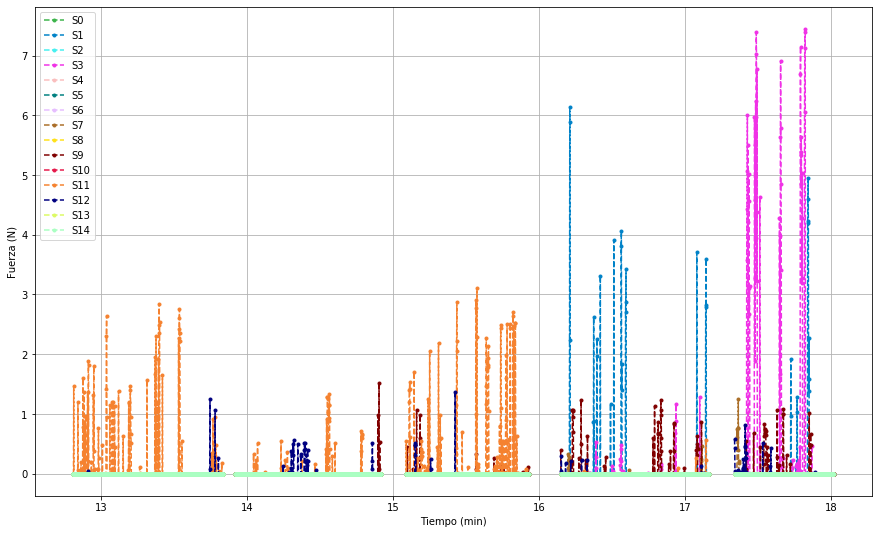

In [11]:
color=[ (60/255.0, 180/255.0, 75/255.0), (0/255.0, 130/255.0, 200/255.0), 
       (70/255.0, 240/255.0, 240/255.0), (240/255.0, 50/255.0, 230/255.0), (250/255.0, 190/255.0, 190/255.0), (0/255.0, 128/255.0, 128/255.0), (230/255.0, 190/255.0, 255/255.0),
       (170/255.0, 110/255.0, 40/255.0), (255/255.0, 225/255.0, 25/255.0),  (128/255.0, 0/255.0, 0/255.0),(230/255.0, 25/255.0, 75/255.0),(245/255.0, 130/255.0, 48/255.0), (0/255.0, 0/255.0, 128/255.0),(220/255.0, 250/255.0, 100/255.0), (170/255.0, 255/255.0, 195/255.0)]
plt.figure(figsize=(15,9))
for i in range(15): #[2]:#
  plt.plot(tiempo_med2_crudo[t1in_med2:t1fin_med2],F_medio1[:,i], '.--',color=color[i], label='S'+str(i))
  plt.plot(tiempo_med2_crudo[t2in_med2:t2fin_med2],F_medio2[:,i], '.--',color=color[i])
  plt.plot(tiempo_med2_crudo[t3in_med2:t3fin_med2],F_medio3[:,i], '.--',color=color[i])
  plt.plot(tiempo_med2_crudo[t4in_med2:t4fin_med2],F_medio4[:,i], '.--',color=color[i])
  plt.plot(tiempo_med2_crudo[t5in_med2:t5fin_med2],F_medio5[:,i], '.--',color=color[i])  
  plt.grid()
  

plt.legend(loc='upper left')
plt.rc('axes',labelsize=25)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.rc('legend',fontsize=12)
plt.xlabel('Tiempo (min)')
plt.ylabel('Fuerza (N)')
plt.show()

In [0]:
#tiempo_med2_crudo[t1in_med2:t1fin_med2]
for i in range(15):
  print(len(F_medio2[:,i]) - sum(F_medio2[:,i]==0))
  

0
0
0
0
0
0
0
0
0
4
0
35
22
0
0


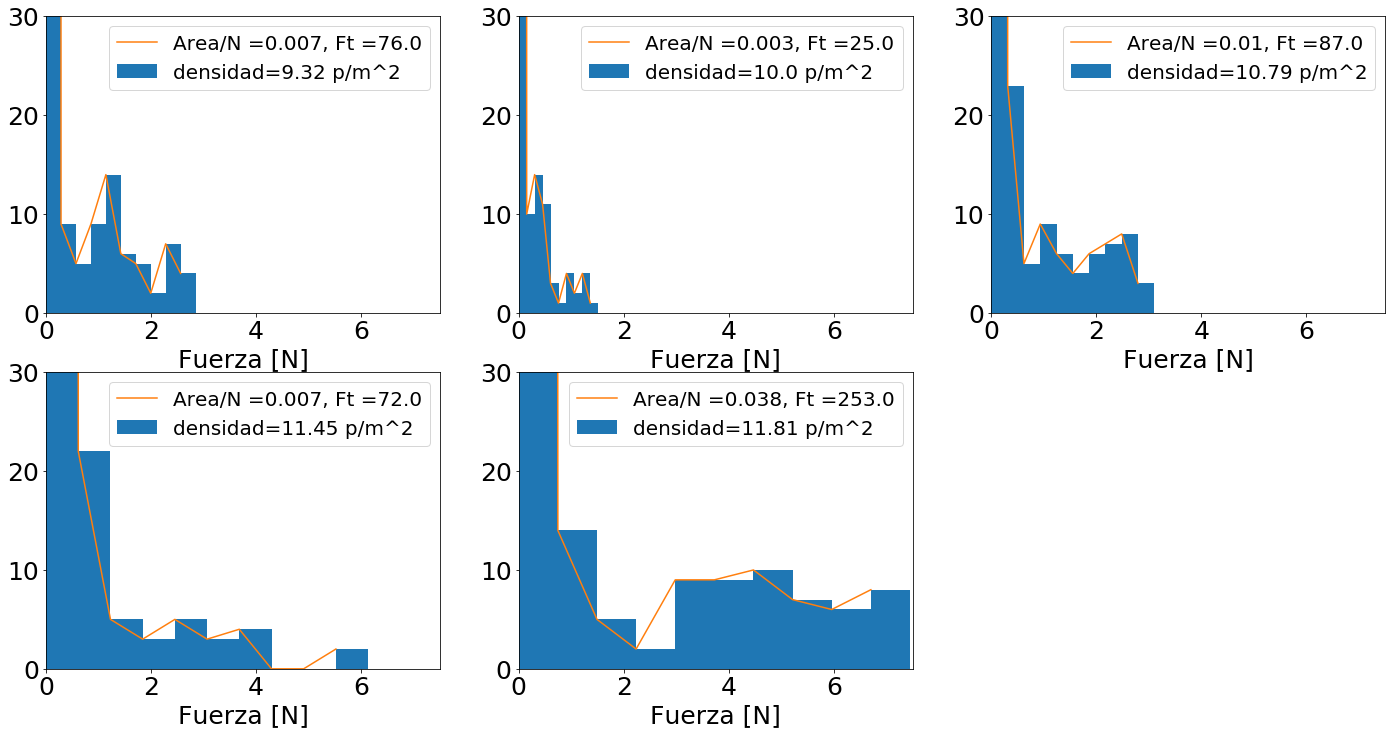

In [75]:

Fuerza1concat=[]
Fuerza2concat=[]
Fuerza3concat=[]
Fuerza4concat=[]
Fuerza5concat=[]

xlimd, xlimu = 0, 7.5
ylimd, ylimu= 0, 30

for i in range(15):
  Fuerza1concat=np.concatenate([F_medio1[:,i],Fuerza1concat])
  Fuerza2concat=np.concatenate([F_medio2[:,i],Fuerza2concat])
  Fuerza3concat=np.concatenate([F_medio3[:,i],Fuerza3concat])
  Fuerza4concat=np.concatenate([F_medio4[:,i],Fuerza4concat])
  Fuerza5concat=np.concatenate([F_medio5[:,i],Fuerza5concat])

orde = 3

plt.figure(figsize=(24,12))
plt.rc('axes',labelsize=25)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.rc('legend',fontsize=20)

plt.subplot(2,3,1)
n1, bins1, patches1 = plt.hist(Fuerza1concat,label='densidad='+str(round(densidad[0],2))+' p/m^2')
a1 = sum(bins1[:-1]*n1)/sum(n1)
ft1 = sum(bins1[:-1]*n1)
plt.plot(bins1[:-1], n1, label='Area/N ='+str(round(a1,orde))+', Ft ='+str(round(ft1)))
plt.legend()
plt.xlabel('Fuerza [N]')
plt.xlim(xlimd, xlimu)
plt.ylim(ylimd, ylimu)
plt.subplot(2,3,2)
n2, bins2, patches2 = plt.hist(Fuerza2concat,label='densidad='+str(round(densidad[1],2))+' p/m^2')
a2 = sum(bins2[:-1]*n2)/sum(n2)
ft2 = sum(bins2[:-1]*n2)
plt.plot(bins2[:-1], n2, label='Area/N ='+str(round(a2,orde))+', Ft ='+str(round(ft2)))
plt.legend()
plt.xlabel('Fuerza [N]')
plt.xlim(xlimd, xlimu)
plt.ylim(ylimd, ylimu)
plt.subplot(2,3,3)
n3, bins3, patches3 = plt.hist(Fuerza3concat,label='densidad='+str(round(densidad[2],2))+' p/m^2')
a3 = sum(bins3[:-1]*n3)/sum(n3)
ft3 = sum(bins3[:-1]*n3)
plt.plot(bins3[:-1], n3, label='Area/N ='+str(round(a3,orde))+', Ft ='+str(round(ft3)))
plt.legend()
plt.xlabel('Fuerza [N]')
plt.xlim(xlimd,xlimu)
plt.ylim(ylimd, ylimu)
plt.subplot(2,3,4)
n4, bins4, patches4 = plt.hist(Fuerza4concat,label='densidad='+str(round(densidad[3],2))+' p/m^2')
a4 = sum(bins4[:-1]*n4)/sum(n4)
ft4 = sum(bins4[:-1]*n4)
plt.plot(bins4[:-1], n4, label='Area/N ='+str(round(a4,orde))+', Ft ='+str(round(ft4)))
plt.legend()
plt.xlabel('Fuerza [N]')
plt.xlim(xlimd,xlimu)
plt.ylim(ylimd, ylimu)
plt.subplot(2,3,5)
n5, bins5, patches5 = plt.hist(Fuerza5concat,label='densidad='+str(round(densidad[4],2))+' p/m^2')
a5 = sum(bins5[:-1]*n5)/sum(n5)
ft5 = sum(bins5[:-1]*n5)
plt.plot(bins5[:-1], n5, label='Area/N ='+str(round(a5,orde))+', Ft ='+str(round(ft5)))
plt.legend()
plt.xlabel('Fuerza [N]')
plt.xlim(xlimd,xlimu)
plt.ylim(ylimd, ylimu)
plt.savefig('hist.png')
plt.show()

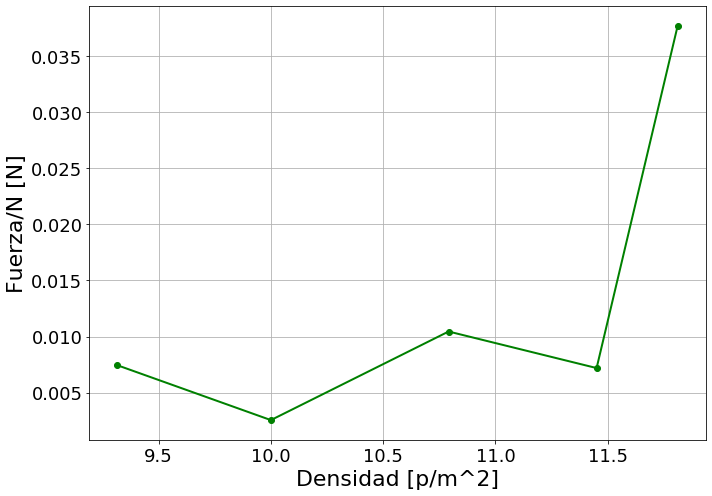

In [88]:
areaf = [a1, a2, a3, a4, a5]
plt.figure(figsize=[10,7])
plt.rc('axes',labelsize=22)
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('legend',fontsize=20)
plt.plot(densidad, areaf, 'g.-', markersize=12, linewidth=2)
plt.grid()
plt.ylabel('Fuerza/N [N]')
plt.xlabel('Densidad [p/m^2]')
plt.tight_layout()
plt.savefig('curva.png')
plt.show()


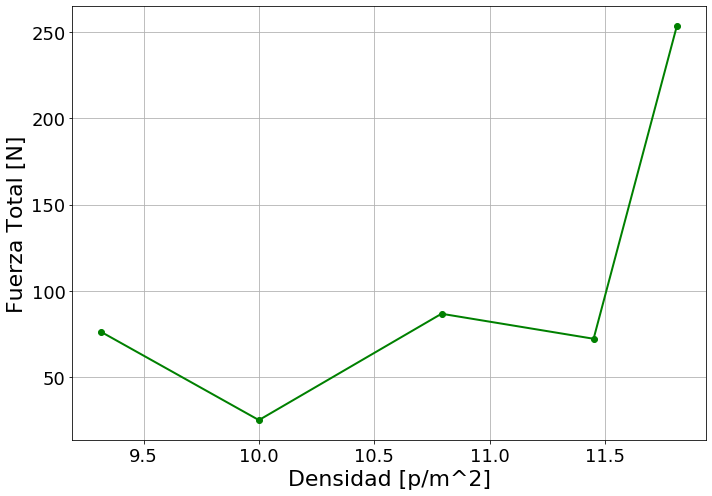

In [89]:
areaf = [a1*sum(n1), a2*sum(n2), a3*sum(n3), a4*sum(n4), a5*sum(n5)]
plt.figure(figsize=[10,7])
plt.rc('axes',labelsize=22)
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.rc('legend',fontsize=20)
plt.plot(densidad, areaf, 'g.-', markersize=12, linewidth=2)
plt.grid()
plt.ylabel('Fuerza Total [N]')
plt.xlabel('Densidad [p/m^2]')
plt.tight_layout()
plt.savefig('curvaconN.png')
plt.show()

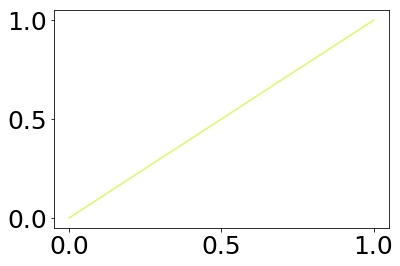

In [0]:
i=1
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10),color=color[i])

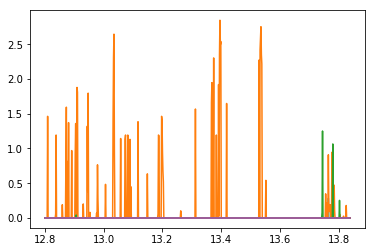

In [0]:
plt.plot(tiempo_med2_crudo[t1in_med2:t1fin_med2],F_medio1)

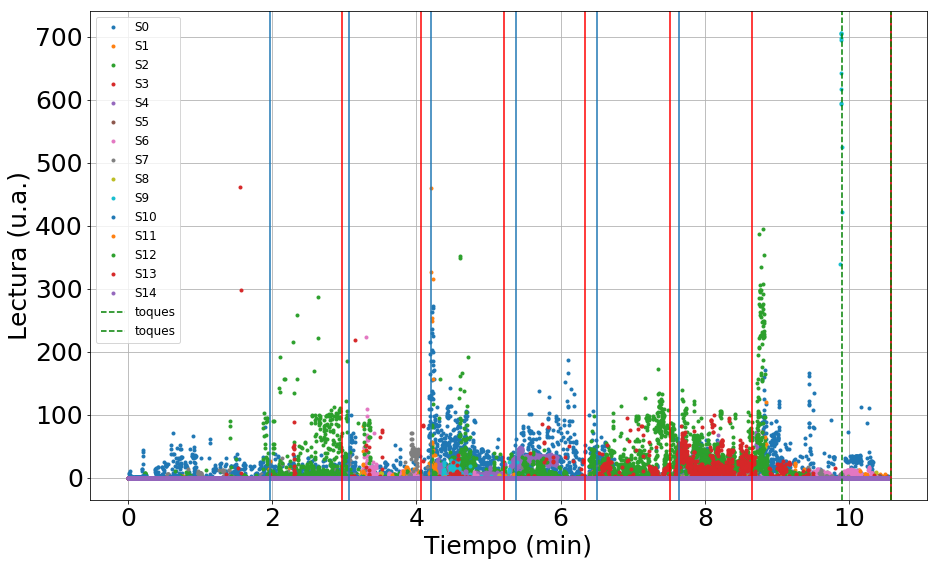

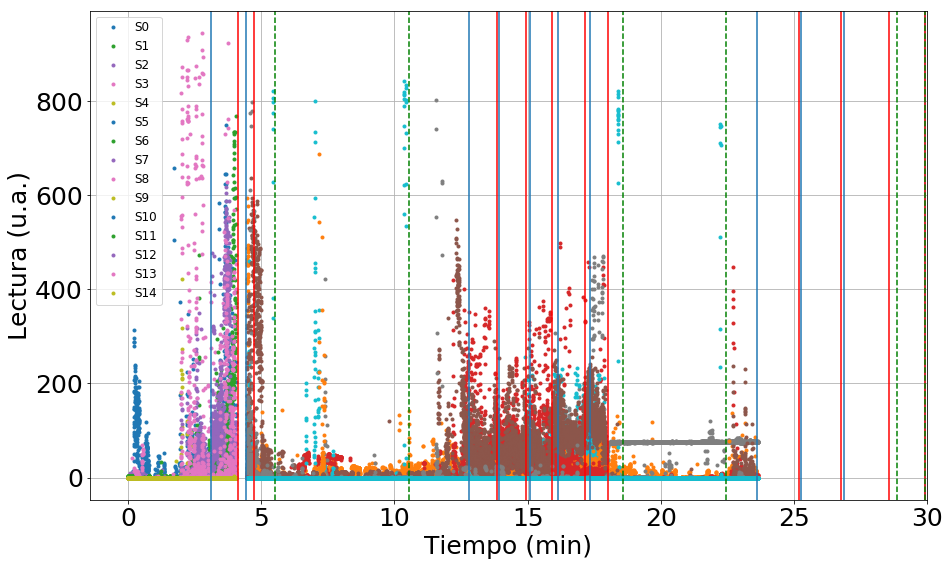

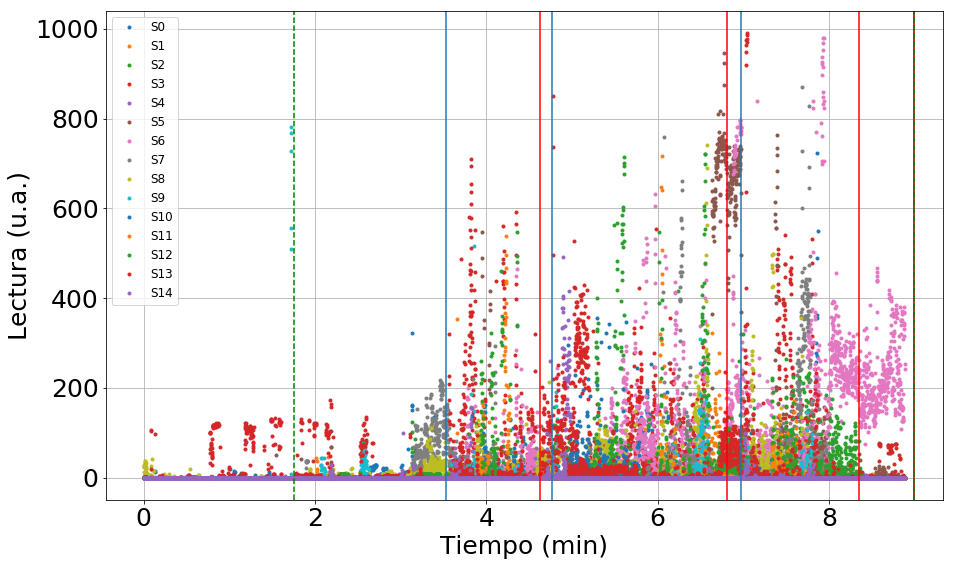

In [0]:
plt.figure(figsize=(15,9))
for i in range(15): #[2]:#
  plt.plot((datos[inimed1:finmed1,0]-datos[inimed1,0])/60000,datos[inimed1:finmed1,i+1], '.', label='S'+str(i))
  plt.grid()
for j in range(len(T_crono[3])):
  plt.axvline(T_crono[3][j])#, label='inicios')
  plt.axvline(T_crono[0][j], color='r')#, label='finales')
for k in range(len(T_crono[2])):
  plt.axvline(T_crono[2][k], color='g', linestyle='--', label='toques')
plt.legend()
plt.xlabel('Tiempo (min)')
plt.ylabel('Lectura (u.a.)')
#plt.savefig('med1.png')
plt.show()

plt.figure(figsize=(15,9))
for i in range(15): #[2]:#
  plt.plot((datos[inimed2:finmed2,0]-datos[inimed2,0]*np.ones(len(datos[inimed2:finmed2,0])))/60000,datos[inimed2:finmed2,i+1], '.', label='S'+str(i))
  plt.plot((datos[inimed3:finmed3,0]-datos[inimed2,0])/60000,datos[inimed3:finmed3,i+1], '.')#, label='S'+str(i))
  plt.grid()
for j in range(len(T_crono[7])):
  plt.axvline(T_crono[7][j])#, label='inicios')
  plt.axvline(T_crono[5][j], color='r')#, label='finales')
for k in range(len(T_crono[6])):
  plt.axvline(T_crono[6][k], color='g', linestyle='--')#, label='toques')
plt.legend()
plt.xlabel('Tiempo (min)')
plt.ylabel('Lectura (u.a.)')

#plt.savefig('med2+3.png')
plt.show()

"""
plt.figure(figsize=(15,9))
for i in range(15): #[2]:#
  plt.plot(datos[inimed3:finmed3,0]/60000,datos[inimed3:finmed3,i+1], '.', label='S'+str(i))
  plt.grid()
plt.legend()
plt.show()
"""

plt.figure(figsize=(15,9))
for i in range(15): #[2]:#
  plt.plot((datos[inimed4:finmed4,0]-datos[inimed4,0])/60000,datos[inimed4:finmed4,i+1], '.', label='S'+str(i))
  plt.grid()
for j in range(len(T_crono[10])):
  plt.axvline(T_crono[10][j])#, label='inicios')
  plt.axvline(T_crono[9][j], color='r')#, label='finales')
for k in range(len(T_crono[11])):
  plt.axvline(T_crono[11][k], color='g',  linestyle='--')#, label='toques')
plt.legend()
plt.xlabel('Tiempo (min)')
plt.ylabel('Lectura (u.a.)')

#plt.savefig('med4.png')
plt.show()

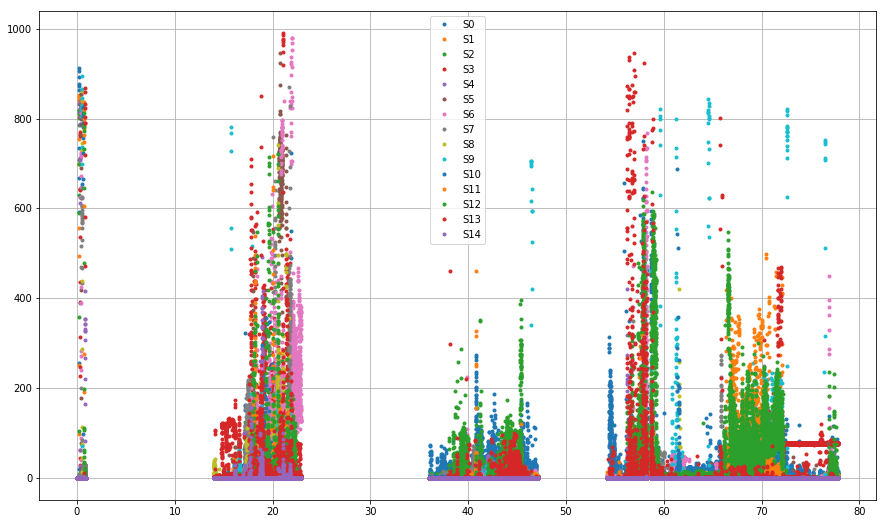

In [0]:
plt.figure(figsize=(15,9))
for i in range(15): #[2]:#
  plt.plot(datos[:,0]/60000,datos[:,i+1], '.', label='S'+str(i))
  plt.grid()
plt.legend()
plt.show()

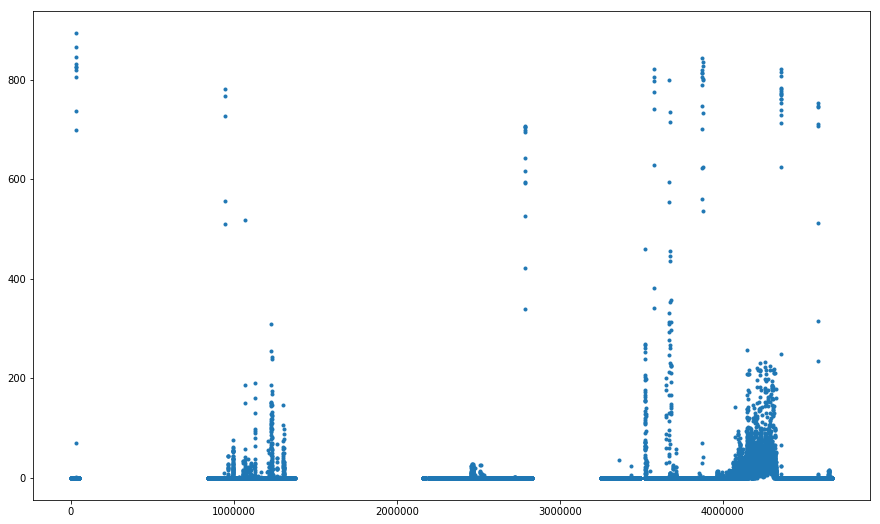

In [0]:
j = 9
inicio, fin = 0 , len(datos[:,0])
plt.figure(figsize=(15,9))
plt.plot(datos[inicio:fin,0], datos[inicio:fin,j+1], '.', label='S'+str(j))
#plt.xlim(0,600)